In [1]:
from time import time
import lightgbm as lgb
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import KFold, TimeSeriesSplit
from scipy.stats import uniform
import datetime
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from scipy import stats
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, validation_curve, KFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline
import gc

In [2]:
# Load original train+test
train = pd.read_pickle('./Data/train_09457_with_additions.pkl')
test = pd.read_pickle('./Data/test_09457_with_additions.pkl')

In [3]:
train.reset_index(inplace=True)
test.reset_index(inplace=True)

In [4]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

X.drop('Date', axis=1, inplace=True)
test.drop('Date', axis=1, inplace=True)

In [8]:
X =X.astype(np.float32)

In [10]:
test = test.astype(np.float32)

In [13]:
del train
gc.collect()

15

In [14]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
          'n_jobs': -1
         }

In [15]:
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Training has finished.')
print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 1	valid_1's auc: 0.908409
Early stopping, best iteration is:
[940]	training's auc: 1	valid_1's auc: 0.908343
Fold 1 finished in 0:06:00.059943
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 1	valid_1's auc: 0.928964
Early stopping, best iteration is:
[1162]	training's auc: 1	valid_1's auc: 0.929138
Fold 2 finished in 0:14:55.196528
Training on fold 3
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999987	valid_1's auc: 0.922951
[2000]	training's auc: 1	valid_1's auc: 0.92326
Early stopping, best iteration is:
[1544]	training's auc: 1	valid_1's auc: 0.923636
Fold 3 finished in 0:24:56.537039
Training on fold 4
Training until validation scores don't improve for 500 rounds.
[1000]	training's auc: 0.999889	valid_1's auc: 0.936342
[2000]	training's auc: 1	valid_1's auc: 0.937122
Early stoppi

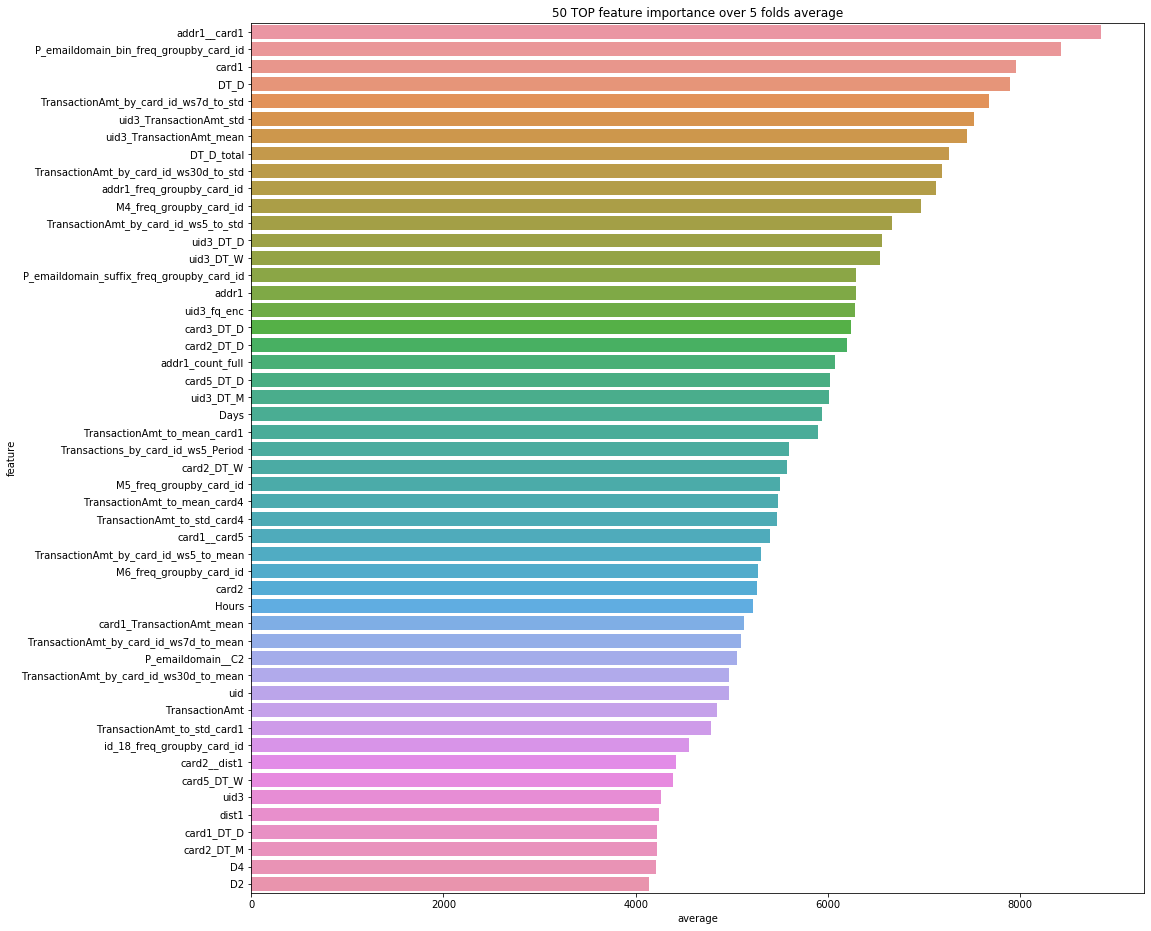

In [16]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

In [15]:
best_iter = 2045#clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=2045, num_leaves=491,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

In [17]:
sub = pd.read_csv(f'./Data/sample_submission.csv')
sub['isFraud'] = clf.predict_proba(test)[:, 1]
sub.to_csv('ieee_with_additions.csv', index=False)